<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [3]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem, stats

import pylab as plt
import seaborn as sns

In [4]:
# datos
cookies = pd.read_csv('data/cookie_cats.csv')
cookies.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [5]:
# transformacion
t1 = pd.crosstab(cookies.version, cookies.retention_1)

t2 = pd.crosstab(cookies.version, cookies.retention_7)

### AB Testing for Day 1

In [6]:
t1

retention_1,False,True
version,,
gate_30,24666,20034
gate_40,25370,20119


In [7]:
#Check if there are unique
#Se puede hacer tb por test 
usuarios=cookies.userid.value_counts(ascending=False)
usuarios[usuarios>1].count()

0

<AxesSubplot:xlabel='version'>

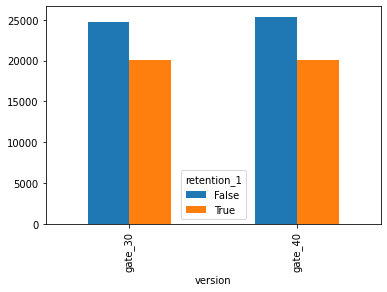

In [8]:
t1.plot(kind='bar')

In [9]:
# muestreo retention_1
control_ret1 = cookies[cookies.version=='gate_30'].sample(n=20034)
tratamiento_ret1= cookies[cookies.version=='gate_40'].sample(n=20034)
ab_test_1=pd.concat([control_ret1, tratamiento_ret1], axis=0)

In [10]:
ab_test_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40068 entries, 6684 to 34212
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          40068 non-null  int64 
 1   version         40068 non-null  object
 2   sum_gamerounds  40068 non-null  int64 
 3   retention_1     40068 non-null  bool  
 4   retention_7     40068 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 1.3+ MB


In [11]:
ab_test_1.version.value_counts()

gate_30    20034
gate_40    20034
Name: version, dtype: int64

In [12]:
tasas_conversion=ab_test_1.groupby('version')['retention_1'] # agrupo por grupo

std=lambda x: np.std(x, ddof=0)    # std

error_std=lambda x: stats.sem(x, ddof=0)   # error standard , (std/sqrt(n))

tasas_conversion=tasas_conversion.agg([np.mean, std, error_std])
tasas_conversion.columns=['conversion_rate', 'std', 'std_error']


tasas_conversion.style.format('{:.3f}')

C:\Users\Irene Aguerri\AppData\Local\Temp\ipykernel_19068\60245887.py:5: DeprecationWarning: Please use `sem` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  error_std=lambda x: stats.sem(x, ddof=0)   # error standard , (std/sqrt(n))


,conversion_rate,std,std_error
version,,,
gate_30,0.449,0.497,0.004
gate_40,0.444,0.497,0.004


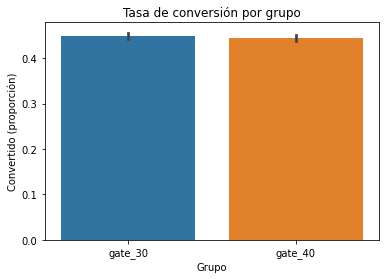

In [13]:
plt.figure(figsize=(6,4))

sns.barplot(x=ab_test_1['version'], 
            y=ab_test_1['retention_1'])

# plt.ylim(0, 0.17)
plt.title('Tasa de conversión por grupo')
plt.xlabel('Grupo')
plt.ylabel('Convertido (proporción)');

La tasa de conversión de la puerta 30 es del 44.9 % mientras que la de la puerta 40 es del 44.1%. Por lo que la tasa del tratamiento es menor que la actual. Ahora comprobaremos si es esta diferencia estadísticamente significativa

In [47]:
# testeo para retention_1
control_res_1=ab_test_1[ab_test_1.version=='gate_30']['retention_1']

tratamiento_res_1=ab_test_1[ab_test_1.version=='gate_40']['retention_1']

In [67]:
tasas_conversion_1=ab_test_1.groupby('version')['retention_1'] # agrupo por grupo

std_1=lambda x: np.std(x, ddof=0)    # std

error_std_1=lambda x: stats.sem(x, ddof=0)   # error standard , (std/sqrt(n))

tasas_conversion_1=tasas_conversion_1.agg([np.mean, std, error_std])
tasas_conversion_1.columns=['conversion_rate', 'std', 'std_error']


tasas_conversion_1.style.format('{:.3f}')

C:\Users\Irene Aguerri\AppData\Local\Temp\ipykernel_19068\2399170491.py:5: DeprecationWarning: Please use `sem` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  error_std=lambda x: stats.sem(x, ddof=0)   # error standard , (std/sqrt(n))


,conversion_rate,std,std_error
version,,,
gate_30,0.449,0.497,0.004
gate_40,0.442,0.497,0.004


In [68]:
observaciones_1=[20034, 20034] 

conversiones_1=[control_res_1.sum(), tratamiento_res_1.sum()]   # conversiones por grupo

print(conversiones_1)
z_score, p_valor = proportions_ztest(conversiones_1, nobs=observaciones_1)  # diferencia significativa
print(z_score)


# intervalos de confianza

(control_a, tratamiento_a), (control_b, tratamiento_b)  = proportion_confint(conversiones_1,  nobs=observaciones_1, alpha=0.05)

[8999, 8854]
1.4574312370671259


In [69]:
print(f'z-score: {z_score:.2f}')
print(f'p-valor: {p_valor:.3f}')
print(f'intervalo conf 95% para grupo control: [{control_a:.3f}, {control_b:.3f}]')
print(f'intervalo conf 95% para grupo tratamiento: [{tratamiento_a:.3f}, {tratamiento_b:.3f}]')

z-score: 1.46
p-valor: 0.145
intervalo conf 95% para grupo control: [0.442, 0.456]
intervalo conf 95% para grupo tratamiento: [0.435, 0.449]


Dado que el p-valor es mayor que 0.05, no podemos rechazar la Hipotesis nula, por lo que el cambio a la puerta 40 no tiene un rendimiento significativamente diferente de la puerta 30. 

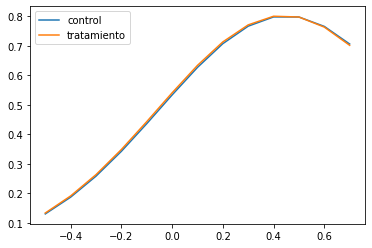

In [71]:
x=[i*.1 for i in range(-5, 8)]  

control_1=[norm.pdf(x, tasas_conversion_1.iloc[0][0], tasas_conversion_1.iloc[0][1]) for x in x] 

tratamiento_1=[norm.pdf(x, tasas_conversion_1.iloc[1][0], tasas_conversion_1.iloc[1][1]) for x in x] 

plt.plot(x, control_1)
plt.plot(x, tratamiento_1)
plt.legend(['control', 'tratamiento']);

## AB Test for day 7

In [28]:
t2

retention_7,False,True
version,,
gate_30,36198,8502
gate_40,37210,8279


In [29]:
#Check if there are unique
#Se puede hacer tb por test 
usuarios=cookies.userid.value_counts(ascending=False)
usuarios[usuarios>1].count()

0

<AxesSubplot:xlabel='version'>

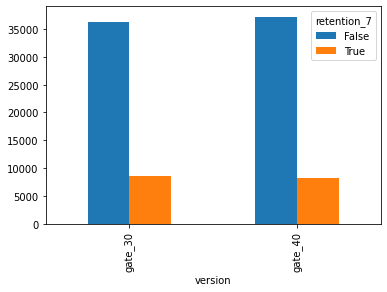

In [30]:
t2.plot(kind='bar')

In [55]:
# muestreo retention_1
control_ret2 = cookies[cookies.version=='gate_30'].sample(n=8279)
tratamiento_ret2= cookies[cookies.version=='gate_40'].sample(n=8279)
ab_test_2=pd.concat([control_ret2, tratamiento_ret2], axis=0)
ab_test_2.tail()

,userid,version,sum_gamerounds,retention_1,retention_7
79391,8789971,gate_40,3,False,False
89378,9910760,gate_40,23,True,False
12488,1383071,gate_40,0,False,False
83123,9209557,gate_40,122,True,False
5601,620624,gate_40,58,True,False


In [56]:
ab_test_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16558 entries, 46189 to 5601
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          16558 non-null  int64 
 1   version         16558 non-null  object
 2   sum_gamerounds  16558 non-null  int64 
 3   retention_1     16558 non-null  bool  
 4   retention_7     16558 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 549.8+ KB


In [57]:
ab_test_2.version.value_counts()

gate_30    8279
gate_40    8279
Name: version, dtype: int64

In [59]:
tasas_conversion_2=ab_test_2.groupby('version')['retention_7'] # agrupo por grupo

std_2=lambda x: np.std(x, ddof=0)    # std

error_std_2=lambda x: stats.sem(x, ddof=0)   # error standard , (std/sqrt(n))

tasas_conversion_2=tasas_conversion_2.agg([np.mean, std, error_std])
tasas_conversion_2.columns=['conversion_rate', 'std', 'std_error']


tasas_conversion_2.style.format('{:.3f}')

C:\Users\Irene Aguerri\AppData\Local\Temp\ipykernel_19068\2399170491.py:5: DeprecationWarning: Please use `sem` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  error_std=lambda x: stats.sem(x, ddof=0)   # error standard , (std/sqrt(n))


,conversion_rate,std,std_error
version,,,
gate_30,0.201,0.401,0.004
gate_40,0.178,0.383,0.004


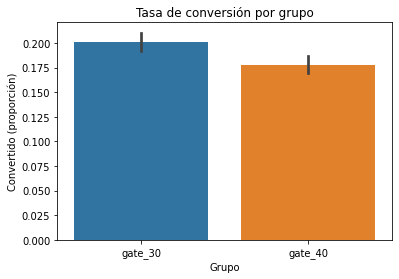

In [60]:
plt.figure(figsize=(6,4))

sns.barplot(x=ab_test_2['version'], 
            y=ab_test_['retention_7'])

# plt.ylim(0, 0.17)
plt.title('Tasa de conversión por grupo')
plt.xlabel('Grupo')
plt.ylabel('Convertido (proporción)');

La tasa de conversión de la puerta 40 es del 17.8 % mientras que la de la puerta 40 es del 20.1%. Por lo que la tasa del tratamiento es menor que la actual. Ahora comprobaremos si es esta diferencia estadísticamente significativa

In [62]:
# testeo para retention_1
control_res_2=ab_test_2[ab_test_2.version=='gate_30']['retention_1']

tratamiento_res_2=ab_test_2[ab_test_2.version=='gate_40']['retention_1']

In [63]:
observaciones_2=[8279, 8279] 

conversiones_2=[control_res_2.sum(), tratamiento_res_2.sum()]   # conversiones por grupo

print(conversiones_2)
z_score, p_valor = proportions_ztest(conversiones_2, nobs=observaciones_2)  # diferencia significativa
print(z_score)


# intervalos de confianza

(control_a, tratamiento_a), (control_b, tratamiento_b)  = proportion_confint(conversiones_2,  nobs=observaciones_2, alpha=0.05)

[3754, 3622]
2.0639480988826135


In [64]:
print(f'z-score: {z_score:.2f}')
print(f'p-valor: {p_valor:.3f}')
print(f'intervalo conf 95% para grupo control: [{control_a:.3f}, {control_b:.3f}]')
print(f'intervalo conf 95% para grupo tratamiento: [{tratamiento_a:.3f}, {tratamiento_b:.3f}]')

z-score: 2.06
p-valor: 0.039
intervalo conf 95% para grupo control: [0.443, 0.464]
intervalo conf 95% para grupo tratamiento: [0.427, 0.448]


Dado que el  𝑝 -valor=0.039 es mayor que  𝛼 =0.05, podemos rechazar la hipótesis nula  𝐻0 , lo que significa que el nuevo cambio de puerta (40) si tiene un rendimiento significativamente diferente al de la puerta 30

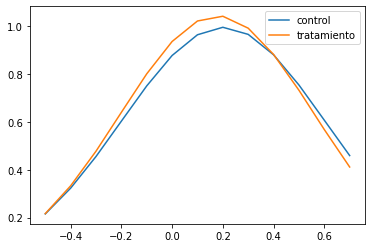

In [65]:
x=[i*.1 for i in range(-5, 8)]  

control_2=[norm.pdf(x, tasas_conversion_2.iloc[0][0], tasas_conversion_2.iloc[0][1]) for x in x] 

tratamiento_2=[norm.pdf(x, tasas_conversion_2.iloc[1][0], tasas_conversion_2.iloc[1][1]) for x in x] 

plt.plot(x, control_2)
plt.plot(x, tratamiento_2)
plt.legend(['control', 'tratamiento']);